Extract features from EmoDB dataset

In [1]:
import librosa
import os
import numpy as np
import pandas as pd

# Example fetures extraction

In [2]:
example_audio = '/datasets/nicolas_facchinetti/EmoDB/data/03a01Fa.wav'
samples, sample_rate = librosa.load(example_audio, sr=None)

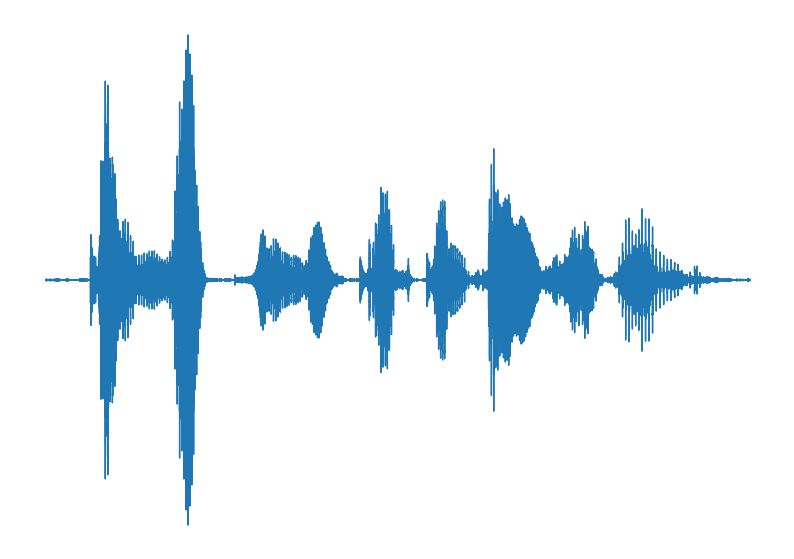

In [3]:
import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.axis('off')
librosa.display.waveshow(samples, sr=sample_rate)

/home/nicolas/.conda/envs/thesis/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  return f(*args, **kwargs)


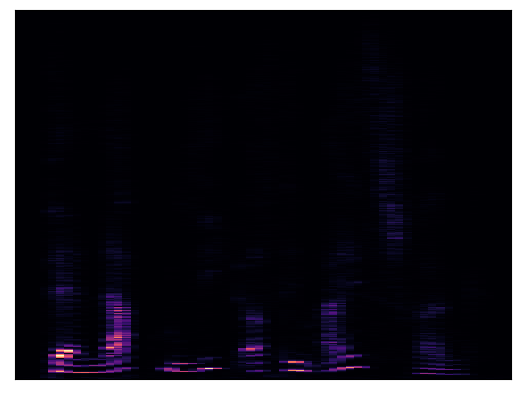

In [4]:
# convert to spectrogram
sgram = librosa.stft(samples, n_fft=2048, hop_length=512)
librosa.display.specshow(sgram)

/tmp/ipykernel_1727012/29967690.py:2: FutureWarning: Pass y=[ 0.00067139  0.00308228  0.00253296 ... -0.00231934 -0.00186157
 -0.00186157] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_scale_sgram = librosa.feature.melspectrogram(samples, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=64)


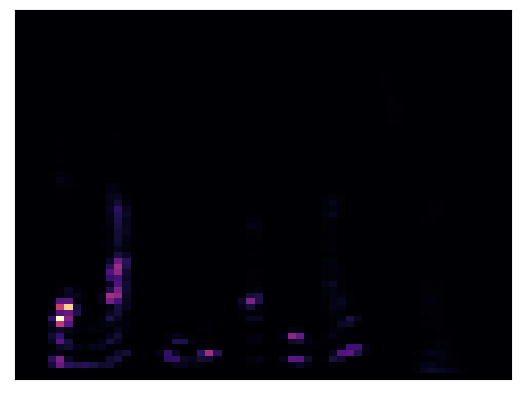

In [5]:
# use the mel-scale instead of raw frequency
mel_scale_sgram = librosa.feature.melspectrogram(samples, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=64)
librosa.display.specshow(mel_scale_sgram)

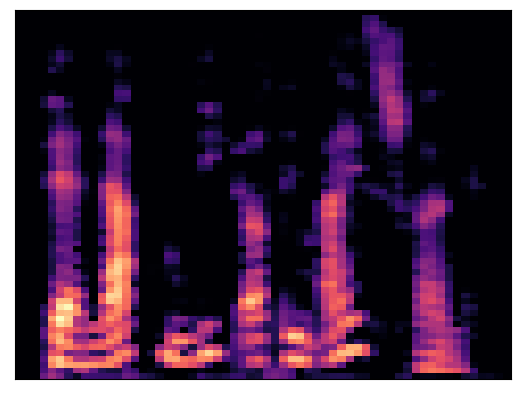

In [6]:
# use the decibel scale to get the final Mel Spectrogram
log_mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
librosa.display.specshow(log_mel_sgram, sr=sample_rate)

# DataFrame with Input Samples

Create Pandas DataFrame with filename and label

In [7]:
label2name = {
    "L": "Boredom",
    "A": "Fear",
    "E": "Disgust",
    "F": "Happiness",
    "T": "Sadness",
    "W": "Anger",
    "N": "Neutral"
}

male = ['03', '10', '11', '12', '15']

dir_path = '/datasets/nicolas_facchinetti/EmoDB/data'
data = []
samples_list = []
for filename in os.listdir(dir_path):
    samples, sr = librosa.load(os.path.join(dir_path, filename), sr=None)
    samples_list.append(samples)
    
    filepath = os.path.join(dir_path, filename)
    length = len(samples)/sr
    cat = label2name[filename[5]]
    actor = filename[0:2]
    gender = 'm' if actor in male else 'f'
    data.append([filepath, filename, cat, actor, gender, length])
    
df_info = pd.DataFrame(data, columns=['filepath', 'filename', 'label', 'actor', 'gender', 'length'])
df_info

,filepath,filename,label,actor,gender,length
0,/datasets/nicolas_facchinetti/EmoDB/data/13a05...,13a05Tc.wav,Sadness,13,f,4.451375
1,/datasets/nicolas_facchinetti/EmoDB/data/14b09...,14b09Ac.wav,Fear,14,f,2.287688
2,/datasets/nicolas_facchinetti/EmoDB/data/11b02...,11b02Na.wav,Neutral,11,m,2.698812
3,/datasets/nicolas_facchinetti/EmoDB/data/09b03...,09b03Fd.wav,Happiness,09,f,3.312500
4,/datasets/nicolas_facchinetti/EmoDB/data/16b10...,16b10Fb.wav,Happiness,16,f,2.583500
...,...,...,...,...,...,...
530,/datasets/nicolas_facchinetti/EmoDB/data/15a04...,15a04Wa.wav,Anger,15,m,1.945375
531,/datasets/nicolas_facchinetti/EmoDB/data/11b03...,11b03Td.wav,Sadness,11,m,5.905000
532,/datasets/nicolas_facchinetti/EmoDB/data/12b02...,12b02Na.wav,Neutral,12,m,2.982063
533,/datasets/nicolas_facchinetti/EmoDB/data/14b01...,14b01Eb.wav,Disgust,14,f,3.291750


Deal with different lenghts

In [8]:
df_info["length"].describe()

count    535.000000
mean       2.779612
std        1.028189
min        1.225500
25%        2.026594
50%        2.590187
75%        3.308406
max        8.978250
Name: length, dtype: float64

Let's keep a length of 3.3, pad the shorter while split the longer. Throw away samples below minimum lenght 1.22

In [9]:
samples_list[0], len(samples_list[0])/sample_rate

(array([-0.03799438, -0.04031372, -0.03955078, ..., -0.00036621,
        -0.00036621, -0.00076294], dtype=float32),
 4.451375)

In [10]:
buffer_length = 3.3*sample_rate
padded = librosa.util.pad_center(samples_list[1], size=buffer_length)
padded, len(padded)/sample_rate

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 3.3)

In [11]:
def split_sample(audio, length, minimum):
    samples_total = len(audio)
    samples_wrote = 0
    segments = []
    
    to_process = samples_total - samples_wrote
    while to_process > minimum:
        segment = audio[samples_wrote : (samples_wrote + length)]
        segments.append(segment)
        samples_wrote += length
        to_process = samples_total - samples_wrote
    return segments

In [12]:
len(samples_list[119])/sample_rate

3.7410625

In [13]:
splitted = split_sample(samples_list[119], int(buffer_length), int(1.22*sample_rate))
splitted

[array([ 0.0012207 ,  0.0012207 , -0.00088501, ...,  0.00390625,
         0.01635742, -0.00265503], dtype=float32)]

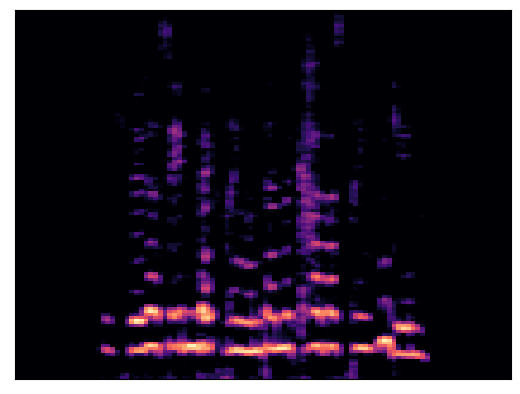

In [14]:
mels = librosa.feature.melspectrogram(y=padded, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=128)
log = librosa.amplitude_to_db(mels, ref=np.min)
librosa.display.specshow(log, sr=sample_rate)

# Dataset processing

Split and pad all the samples, then extract log Mel-specotrograms from all the samples

In [15]:
mod_samples = []
sgram_list = []
mod_data = []
for count, samples in enumerate(samples_list):
    metadata = df_info.iloc[count]
    
    # split larger segmtents
    samples = [samples]
    if metadata["length"] >= buffer_length/sample_rate:
        samples = split_sample(samples[0], int(buffer_length), int(1.22*sample_rate))
    
    # pad segments
    for num, s in enumerate(samples):
        padded = librosa.util.pad_center(s, size=buffer_length)
        mod_samples.append(padded)
        
        mod_data.append([metadata["filepath"], metadata["filename"], str(num), metadata["label"], metadata["actor"], metadata["gender"], len(padded)/sample_rate])
        
        # compute log mel-spectrograms
        mel_scale_sgram = librosa.feature.melspectrogram(y=padded, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=128)
        log_mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
        sgram_list.append(log_mel_sgram)
df_info_mod = pd.DataFrame(mod_data, columns=['filepath', 'filename', 'chunk', 'label', 'actor', 'gender', 'length'])


df_info_mod

,filepath,filename,chunk,label,actor,gender,length
0,/datasets/nicolas_facchinetti/EmoDB/data/13a05...,13a05Tc.wav,0,Sadness,13,f,3.3
1,/datasets/nicolas_facchinetti/EmoDB/data/14b09...,14b09Ac.wav,0,Fear,14,f,3.3
2,/datasets/nicolas_facchinetti/EmoDB/data/11b02...,11b02Na.wav,0,Neutral,11,m,3.3
3,/datasets/nicolas_facchinetti/EmoDB/data/09b03...,09b03Fd.wav,0,Happiness,09,f,3.3
4,/datasets/nicolas_facchinetti/EmoDB/data/16b10...,16b10Fb.wav,0,Happiness,16,f,3.3
...,...,...,...,...,...,...,...
560,/datasets/nicolas_facchinetti/EmoDB/data/11b03...,11b03Td.wav,0,Sadness,11,m,3.3
561,/datasets/nicolas_facchinetti/EmoDB/data/11b03...,11b03Td.wav,1,Sadness,11,m,3.3
562,/datasets/nicolas_facchinetti/EmoDB/data/12b02...,12b02Na.wav,0,Neutral,12,m,3.3
563,/datasets/nicolas_facchinetti/EmoDB/data/14b01...,14b01Eb.wav,0,Disgust,14,f,3.3


Class balance

In [16]:
df_info_mod.label.value_counts()

Anger        128
Sadness       83
Boredom       82
Neutral       79
Happiness     71
Fear          69
Disgust       53
Name: label, dtype: int64

Create folders for images labels

In [17]:
directory = r'/datasets/nicolas_facchinetti/processed_data/EmoDB/images/'
for l in df_info_mod.label.unique():
    newpath = directory+str(l)
    if not os.path.exists(newpath):
        os.makedirs(newpath)

Save images to disk

In [18]:
image_metadata = []
for count, sample in enumerate(sgram_list):
    # label and filename
    label = df_info_mod.iloc[count]["label"]
    chunk = df_info_mod.iloc[count]["chunk"]
    file = df_info_mod.iloc[count]["filename"]
    filename = f'/datasets/nicolas_facchinetti/processed_data/EmoDB/images/{label}/{file}_{chunk}.png'
    # save image to local drive
    img = librosa.display.specshow(sample, sr=sr, n_fft=2048, hop_length=512)
    plt.savefig(filename)
    plt.clf()
    image_metadata.append([filename, label])

<Figure size 640x480 with 0 Axes>

# Save metadata

In [19]:
image_metadata_df = pd.DataFrame(image_metadata, columns=["path", "label"])
image_metadata_df.head()

,path,label
0,/datasets/nicolas_facchinetti/processed_data/E...,Sadness
1,/datasets/nicolas_facchinetti/processed_data/E...,Fear
2,/datasets/nicolas_facchinetti/processed_data/E...,Neutral
3,/datasets/nicolas_facchinetti/processed_data/E...,Happiness
4,/datasets/nicolas_facchinetti/processed_data/E...,Happiness


In [20]:
image_metadata_df.to_csv("/datasets/nicolas_facchinetti/processed_data/EmoDB/processed_images.csv", index=False)

In [21]:
df_info_mod.head()

,filepath,filename,chunk,label,actor,gender,length
0,/datasets/nicolas_facchinetti/EmoDB/data/13a05...,13a05Tc.wav,0,Sadness,13,f,3.3
1,/datasets/nicolas_facchinetti/EmoDB/data/14b09...,14b09Ac.wav,0,Fear,14,f,3.3
2,/datasets/nicolas_facchinetti/EmoDB/data/11b02...,11b02Na.wav,0,Neutral,11,m,3.3
3,/datasets/nicolas_facchinetti/EmoDB/data/09b03...,09b03Fd.wav,0,Happiness,09,f,3.3
4,/datasets/nicolas_facchinetti/EmoDB/data/16b10...,16b10Fb.wav,0,Happiness,16,f,3.3


In [22]:
df_info_mod.to_csv("/datasets/nicolas_facchinetti/processed_data/EmoDB/processed_metadata.csv", index=False)

# Split spectrograms data in train/test

Split in train/test set

In [23]:
sgram_list[0].shape

(128, 104)

In [24]:
X = np.array(sgram_list)
X.shape

(565, 128, 104)

Reshape data to fed in CNN model

In [25]:
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
X.shape

(565, 128, 104, 1)

One-hot encode labels

In [26]:
df_info_mod["label"]

0        Sadness
1           Fear
2        Neutral
3      Happiness
4      Happiness
         ...    
560      Sadness
561      Sadness
562      Neutral
563      Disgust
564    Happiness
Name: label, Length: 565, dtype: object

In [27]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(df_info_mod["label"]).reshape(-1,1)).toarray()
encoder.categories_, Y, Y.shape

([array(['Anger', 'Boredom', 'Disgust', 'Fear', 'Happiness', 'Neutral',
         'Sadness'], dtype=object)],
 array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]]),
 (565, 7))

Divide in train/test data

In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=30, shuffle=True, stratify=Y)
x_train.shape , y_train.shape, x_test.shape, y_test.shape

((452, 128, 104, 1), (452, 7), (113, 128, 104, 1), (113, 7))

Save data for future computations

In [29]:
np.save('/datasets/nicolas_facchinetti/processed_data/EmoDB/first_experiment/x_train.npy', x_train)
np.save('/datasets/nicolas_facchinetti/processed_data/EmoDB/first_experiment/x_test.npy', x_test)
np.save('/datasets/nicolas_facchinetti/processed_data/EmoDB/first_experiment/y_train.npy', y_train)
np.save('/datasets/nicolas_facchinetti/processed_data/EmoDB/first_experiment/y_test.npy', y_test)

# Split spectrogram images in train/test

In [30]:
import tensorflow as tf
img_height = 256
img_width = 256

2022-10-27 16:30:14.945875: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [31]:
def process_path_image(file_path):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # Resize the image to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # Scale pixelin [0,1] interval
    img /= 255.0
    return img

In [32]:
p = process_path_image(image_metadata_df.path[0])
p.shape, p

2022-10-27 16:30:15.748675: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-27 16:30:15.749633: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-10-27 16:30:15.854105: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:15:00.0 name: NVIDIA TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.78GiB deviceMemoryBandwidth: 607.97GiB/s
2022-10-27 16:30:15.854190: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-10-27 16:30:15.856884: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-10-27 16:30:15.856968: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-1

(TensorShape([256, 256, 3]),
 <tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
 array([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        ...,
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1

In [33]:
X_image = np.array([process_path_image(f) for f in image_metadata_df.path])
X_image.shape

(565, 256, 256, 3)

In [34]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_image, Y, test_size=0.20, random_state=30, shuffle=True, stratify=Y)
x_train.shape , y_train.shape, x_test.shape, y_test.shape

((452, 256, 256, 3), (452, 7), (113, 256, 256, 3), (113, 7))

Save data for future computations

In [35]:
np.save('/datasets/nicolas_facchinetti/processed_data/EmoDB/first_experiment/x_im_train.npy', x_train)
np.save('/datasets/nicolas_facchinetti/processed_data/EmoDB/first_experiment/x_im_test.npy', x_test)
np.save('/datasets/nicolas_facchinetti/processed_data/EmoDB/first_experiment/y_im_train.npy', y_train)
np.save('/datasets/nicolas_facchinetti/processed_data/EmoDB/first_experiment/y_im_test.npy', y_test)

In [36]:
np.save('/datasets/nicolas_facchinetti/processed_data/EmoDB/first_experiment/x_im.npy', X_image)
np.save('/datasets/nicolas_facchinetti/processed_data/EmoDB/first_experiment/y_im.npy', Y)